# Признаки для объединенного датасета submissions_train.csv и submission_data_test.csv

Импортируем библиотеки и делаем некоторые настройки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from collections import Counter

In [3]:
sns.set(rc={'figure.figsize': (20, 10)})
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

Загружаем данные о статусах сабмитов

In [5]:
submissions = pd.read_csv('DATA\\submissions_all_two_days.zip', compression='zip')

Сводная таблица по всем категориям из submission_status

In [6]:
first_data = submissions.pivot_table(index='user_id',
                                     columns='submission_status',
                                     values='step_id',
                                     aggfunc='count',
                                     fill_value=0).reset_index()

In [7]:
#уберем индекс submission_status
first_data.columns
first_data.columns.name
first_data.columns.name = None

Переименование колонок

In [8]:
first_data = first_data.rename(columns={'correct': 'c_count',
                                        'wrong': 'w_count'})

Сводная таблица по всем категориям для уникальных step_id

In [9]:
second_data = submissions.pivot_table(index='user_id',
                                      columns='submission_status',
                                      values='step_id',
                                      aggfunc='nunique',
                                      fill_value=0).reset_index()

In [10]:
second_data.columns
second_data.columns.name
second_data.columns.name = None

In [11]:
second_data = second_data.rename(columns={'correct': 'c_uniq',
                                          'wrong': 'w_uniq'})

Соединяем сабмиты уникальные и нет

In [12]:
first_data = first_data.merge(second_data, on='user_id', how='inner')

Добавим новые признаки

In [13]:
# разности количества и уникальных значений "correct" и "wrong"
first_data['c_diff'] = first_data.c_count - first_data.c_uniq
first_data['w_diff'] = first_data.w_count - first_data.w_uniq

In [14]:
# отношения количества и уникальных значений "correct" и "wrong"
first_data['c_div'] = (first_data.c_count / first_data.c_uniq)
first_data['w_div'] = (first_data.w_count / first_data.w_uniq)

In [15]:
first_data = first_data.fillna(1)# Заполним пропуски на 1

Сделаем выборку всех step_id для каждого пользователя

In [16]:
user_steps = submissions.groupby('user_id').step_id.unique().to_frame() \
             .reset_index().rename(columns={'step_id': 'steps_list'})

Отношение суммы step_id к сумме step_id если-бы учашийся проходил их в "идеальном" порядке

In [17]:
# загрузим "идеальный" порядок step_id
ideal_steps = pd.read_csv('DATA\\ideal_steps_submissions_all.csv')

In [18]:
# сумма степов пользователя, дальше заполнил в цикле
user_steps['steps_sum'] = np.nan

In [19]:
for i in range(len(user_steps)):
    user_steps['steps_sum'][i] = sum(user_steps.steps_list[i])

In [20]:
# сумма степов "идеального" порядка, дальше заполнил
user_steps['ideal_steps_sum'] = np.nan

In [21]:
for i in range(len(user_steps)):
    s = 0
    for j in range(len(user_steps.steps_list[i])):
         s = s + ideal_steps.step_id[j]
    user_steps['ideal_steps_sum'][i] = s

In [22]:
# признак
user_steps['S_steps_ratio']=user_steps.steps_sum/user_steps.ideal_steps_sum

In [23]:
# удалил ненужное
user_steps = user_steps.drop(['steps_list',
                              'steps_sum',
                              'ideal_steps_sum'], axis=1)

Добавляем признаки в общую таблицу

In [24]:
first_data = first_data.merge(user_steps, on='user_id', how='inner')

Далее еще признаки:  
* количество пользователей с одинаковыми значениями c_uniq -  c_freq,  
* их отношение к количеству всех пользователей - c_density,  
* произведение колонок - c_uniq * S_steps_ratio,  
* отношение частот текущей к следующей на графике - c_freq[i] / c_freq[i+1],  
* признак относительных частот с весами - (c_freq[i]/c_freq[i+1]) * (c_uniq * S_steps_ratio)

In [25]:
c_dict = Counter(first_data.c_uniq)# словарик
c_dict[0] = 25418 - 12743 + 199# поправил количество для нулевых значений

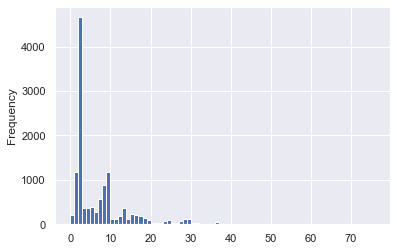

In [26]:
# посмотрим на распределение c_uniq
first_data.c_uniq.plot.hist(bins=76)

In [27]:
# создаем колонки и заполним их в цикле
first_data['c_freq'] = np.nan
first_data['c_density'] = np.nan

In [28]:
for i in range(len(first_data)):
    first_data['c_freq'][i] = c_dict.get(first_data.c_uniq[i])
    first_data['c_density'][i] = c_dict.get(first_data.c_uniq[i]) / 25418

In [29]:
first_data['c_uniq*S_steps_ratio'] = first_data.c_uniq * first_data.S_steps_ratio

In [30]:
# создаем вспомогательный столбец и расчитываем его значения
first_data['c_freq[i+1]'] = np.nan

In [31]:
for i in range(len(first_data)):
    first_data['c_freq[i+1]'][i] = c_dict.get((first_data.c_uniq[i] + 1))

In [32]:
first_data['c_freq[i]/c_freq[i+1]'] = first_data['c_freq'] / first_data['c_freq[i+1]']

In [33]:
# удалим вспомогательный столбец
first_data = first_data.drop(['c_freq[i+1]'], axis=1)

In [34]:
# пропуски заменим на 1 для редких частот
first_data = first_data.fillna(1)

In [35]:
# наконец, признак относительных частот с весами
first_data['(c_freq[i]/c_freq[i+1])*(c_uniq*S_steps_ratio)'] = \
first_data['c_freq[i]/c_freq[i+1]'] * first_data['c_uniq*S_steps_ratio']

Какой был последний сабмит: correct или wrong

In [36]:
# определяем последний timestamp
step_end = submissions.groupby('user_id').timestamp.max().to_frame() \
           .reset_index().rename(columns={'timestamp': 'end_timestamp'})

In [37]:
# соединяем таблицы
step_end = step_end.merge(submissions, on='user_id', how='inner')

In [38]:
del submissions

In [39]:
# отбор строк с последним сабмитом
step_end = step_end[step_end['end_timestamp'] == step_end['timestamp']]

In [40]:
#для повторяющихся оставляем последнюю строку и заполняем новые колонки
step_end = step_end.drop_duplicates(subset=['user_id'], keep='last')

In [41]:
step_end['end_correct'] = (step_end.submission_status == 'correct')

In [42]:
step_end['end_wrong'] = (step_end.submission_status == 'wrong')

In [43]:
step_end = step_end.replace({True: 1, False: 0})

In [44]:
# удаляем ненужное
step_end = step_end. drop(['end_timestamp', 'step_id', 'timestamp',
                           'submission_status', 'min_timestamp',
                           'date_time', 'date', 'day', 'month', 
                           'year', 'week', 'weekday'], axis=1)

Добавляем в общую таблицу

In [45]:
first_data = first_data.merge(step_end, on='user_id', how='inner')

Сохраним результаты в файл:

In [46]:
first_data.to_csv('DATA\\feature_data_submissions_16.zip', index=False,  compression='zip')

In [47]:
first_data

,user_id,c_count,w_count,c_uniq,w_uniq,c_diff,w_diff,c_div,w_div,S_steps_ratio,c_freq,c_density,c_uniq*S_steps_ratio,c_freq[i]/c_freq[i+1],(c_freq[i]/c_freq[i+1])*(c_uniq*S_steps_ratio),end_correct,end_wrong
0,2,2,0,2,0,0,0,1.000000,1.0,1.000000,4663.0,0.183453,2.000000,12.671196,25.342391,1,0
1,3,4,4,4,2,0,2,1.000000,2.0,0.594120,372.0,0.014635,2.376480,0.946565,2.249492,1,0
2,5,2,2,2,1,0,1,1.000000,2.0,1.000000,4663.0,0.183453,2.000000,12.671196,25.342391,1,0
3,8,9,21,9,7,0,14,1.000000,3.0,1.010068,1183.0,0.046542,9.090613,9.776860,88.877648,1,0
4,12,1,0,1,0,0,0,1.000000,1.0,1.000000,1181.0,0.046463,1.000000,0.253270,0.253270,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12738,26794,24,7,22,5,2,2,1.090909,1.4,0.998231,40.0,0.001574,21.961072,0.533333,11.712572,1,0
12739,26796,2,3,2,1,0,2,1.000000,3.0,1.000000,4663.0,0.183453,2.000000,12.671196,25.342391,1,0
12740,26797,2,0,2,0,0,0,1.000000,1.0,1.000000,4663.0,0.183453,2.000000,12.671196,25.342391,1,0
12741,26798,2,1,2,1,0,0,1.000000,1.0,1.000000,4663.0,0.183453,2.000000,12.671196,25.342391,1,0


In [48]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12743 entries, 0 to 12742
Data columns (total 17 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   user_id                                         12743 non-null  int64  
 1   c_count                                         12743 non-null  int64  
 2   w_count                                         12743 non-null  int64  
 3   c_uniq                                          12743 non-null  int64  
 4   w_uniq                                          12743 non-null  int64  
 5   c_diff                                          12743 non-null  int64  
 6   w_diff                                          12743 non-null  int64  
 7   c_div                                           12743 non-null  float64
 8   w_div                                           12743 non-null  float64
 9   S_steps_ratio                          